In [82]:
import os
import statistics
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (15, 5)

In [66]:
def parse_csv(file_name):
    data = {}
    cur_data = None
    with open(file_name) as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith("ultrasound"):  # New sensor
                sensor_name = line[len("ultrasound"):]
                data[sensor_name] = []
                cur_data = data[sensor_name]
                continue
            line_parts = line.split(",")
            assert len(line_parts) == 2
            if line_parts[0] == "time" and line_parts[1] == "distance":  # correct header
                continue
            try:
                time_stamp = float(line_parts[0])
                distance = float(line_parts[1])
                cur_data.append((time_stamp, distance))
            except ValueError:
                print(f"Could not parse data line '{line}'")
    return data

In [67]:
def plot_data(axis, data, start_at_time_zero=True, label_prefix=None):
    for name in sorted(data.keys()):
        plt_data = data[name]
        time_offset = plt_data[0][0] if start_at_time_zero else 0.0
        x_vals = [d[0] - time_offset for d in plt_data]
        y_vals = [d[1] for d in plt_data]
        axis.plot(x_vals, y_vals, label=name)
        if label_prefix is not None:
            axis.set_title(label_prefix)
    axis.legend()

In [68]:
a45_into_files = []
a45_from_files = []
a45_into_from_files = []
for log_file in os.listdir("logs/"):
    if log_file.startswith("hall_angle_45_into_hall_"):
        a45_into_files.append(log_file)
    elif log_file.startswith("hall_angle_45_from_hall_"):
        a45_from_files.append(log_file)
    elif log_file.startswith("hall_angle_45_into_from_hall_"):
        a45_into_from_files.append(log_file)
        
def parse_and_merge(log_file, all_data):
    data = parse_csv("logs/" + log_file)
    run_number = log_file[len("hall_angle_45_into_hall_"):-len(".csv")]
    for name, values in data.items():
        all_data[f"run_{run_number}"] = values
    return all_data

data_empty = parse_csv("logs/hall_angle_45_empty.csv")

data_into = {}
for into_file in a45_into_files:
    parse_and_merge(into_file, data_into)

data_from = {}
for from_file in a45_from_files:
    parse_and_merge(from_file, data_from)

data_into_from = {}
for if_file in a45_into_from_files:
    parse_and_merge(if_file, data_into_from)

    
#data = parse_csv("logs/hall_angle_45_into_from_hall_three_times_1.csv")

Could not parse data line '1600275128.9727437,'
Could not parse data line '1600275153.0327346,'
Could not parse data line '1600275160.2526813,'
Could not parse data line '1600275243.2718127,'
Could not parse data line '1600275258.910566,'
Could not parse data line '1600275339.5224042,'
Could not parse data line '1600274534.633181,'
Could not parse data line '1600274653.740841,'
Could not parse data line '1600274580.3526177,'


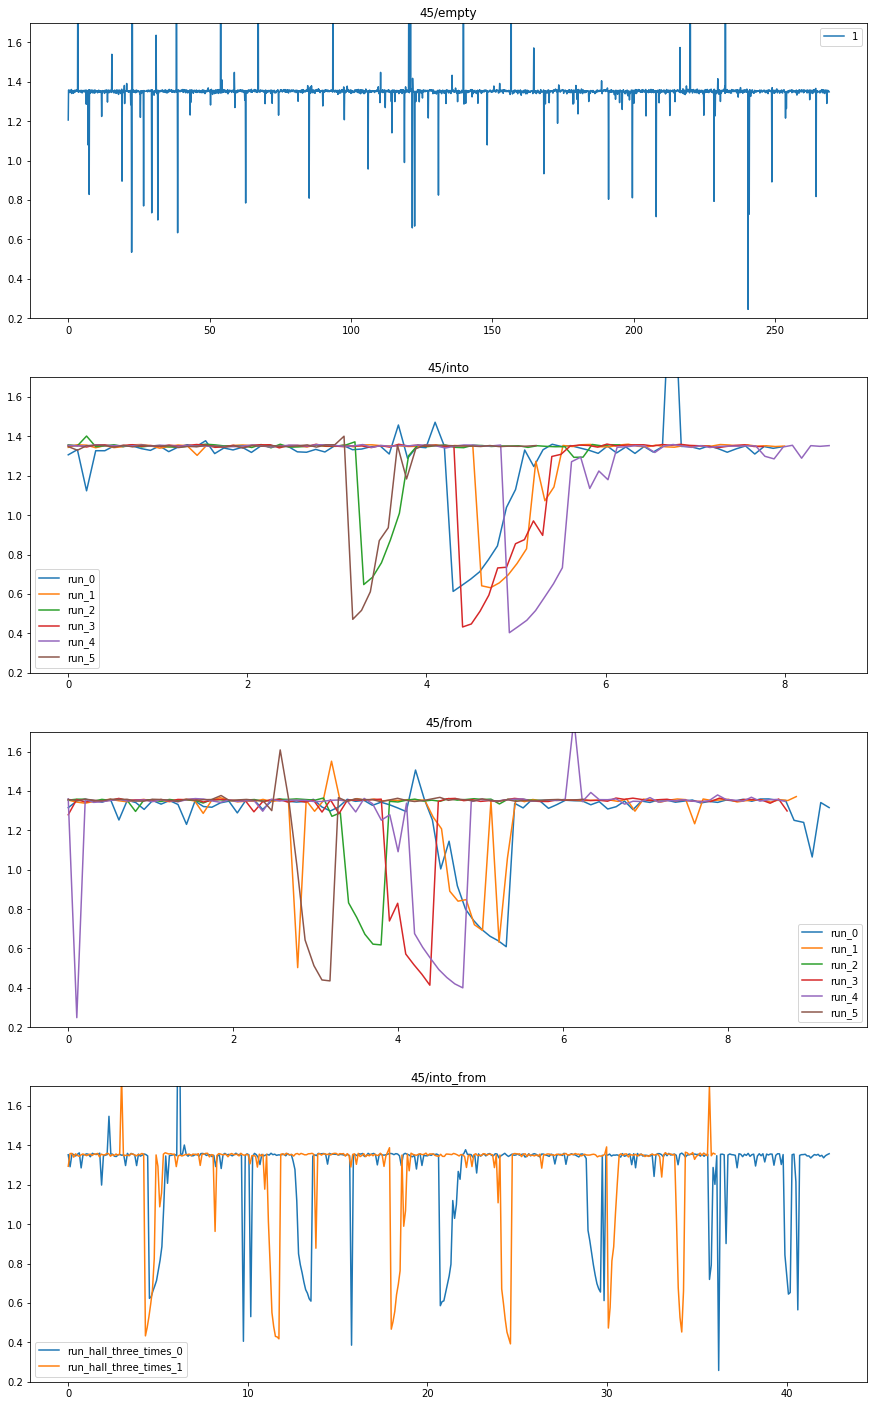

In [83]:
fig, axes = plt.subplots(4,1, figsize=(15,25))
ylim = [0.2, 1.7]
for a in axes:
    a.set_ylim(ylim)
plot_data(axes[0], data_empty, label_prefix="45/empty")
plot_data(axes[1], data_into, label_prefix="45/into")
plot_data(axes[2], data_from, label_prefix="45/from")
plot_data(axes[3], data_into_from, label_prefix="45/into_from")

Median: 1.352735137939453


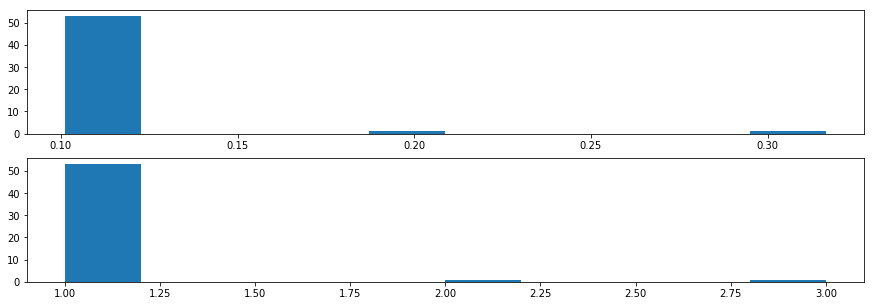

In [96]:
def check_noise(data, max_sane_data_delta=0.1):
    for name, values in data.items():
        yvals = [val[1] for val in values]
    median = statistics.median(yvals)
    print(f"Median: {median}")
    insane_windows = []
    insane_windows_count = []
    for name, values in data.items():
        cur_window_start = None
        cur_window_count = None
        for val in values:
            insane_data = abs(val[1] - median) > max_sane_data_delta
            if insane_data:
                if cur_window_start is None:
                    cur_window_start = val[0]
                    cur_window_count = 1
                else:
                    cur_window_count += 1
            else:
                if cur_window_start is not None:
                    insane_windows.append(val[0] - cur_window_start)
                    insane_windows_count.append(cur_window_count)
                    cur_window_start = None
                    cur_window_count = None
    #print("\n".join(["%.2f" % d for d  in insane_windows]))
    fig, axes = plt.subplots(2, 1)
    axes[0].hist(insane_windows)
    axes[1].hist(insane_windows_count)
    #axes[2].plot(insane_windows_count)
    
check_noise(data_empty, 0.1)